In [1]:
#################################################################
# Este códgio foi escrito com uma enorme influência do códgio   #
# disponivel nos slides da cadeira de ANADI (aulas Teoricas e   #
# correções dos exercicios das aulas Teorico-Praticas).         #
#                                                               #
# Ele também foi escrito com o suporte da ferramenta "ChatGPT". #
#################################################################

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt
import seaborn  as sns
from sklearn.model_selection import train_test_split
from pandas.core.common import random_state
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, plot_tree
import math
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

In [2]:
# Carregar o ficheiro CSV
df = pd.read_csv("AIRPOL_data.csv", sep=';')

#Remover colunas desnecessárias
df = df.iloc[:, :8]

# Corrigir vírgulas em números europeus (por pontos)
df['Affected_Population'] = df['Affected_Population'].str.replace(",", ".").astype(float)
df['Populated_Area[km2]'] = df['Populated_Area[km2]'].str.replace(",", ".").astype(float)
df['Air_Pollution_Average[ug/m3]'] = df['Air_Pollution_Average[ug/m3]'].str.replace(",", ".").astype(float)
df['Value'] = df['Value'].str.replace(",", ".").astype(float)

# Verificar as dimensões do dataset
print("Dimensão do dataset:", df.shape)

# Mostrar um sumário estatístico
print(df.describe(include='all'))

# Ver as primeiras linhas
df.head()

Dimensão do dataset: (49140, 8)
        Country NUTS_Code Air_Pollutant Outcome  Affected_Population  \
count     49140     49140         49140   49140         4.914000e+04   
unique       42      1755             3       6                  NaN   
top     Germany        BA         PM2.5  Asthma                  NaN   
freq      13224       116         29682   10254                  NaN   
mean        NaN       NaN           NaN     NaN         1.023692e+06   
std         NaN       NaN           NaN     NaN         9.085726e+06   
min         NaN       NaN           NaN     NaN         2.674000e+03   
25%         NaN       NaN           NaN     NaN         1.069040e+05   
50%         NaN       NaN           NaN     NaN         2.388280e+05   
75%         NaN       NaN           NaN     NaN         5.988800e+05   
max         NaN       NaN           NaN     NaN         4.680626e+08   

        Populated_Area[km2]  Air_Pollution_Average[ug/m3]          Value  
count          4.914000e+04 

,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0


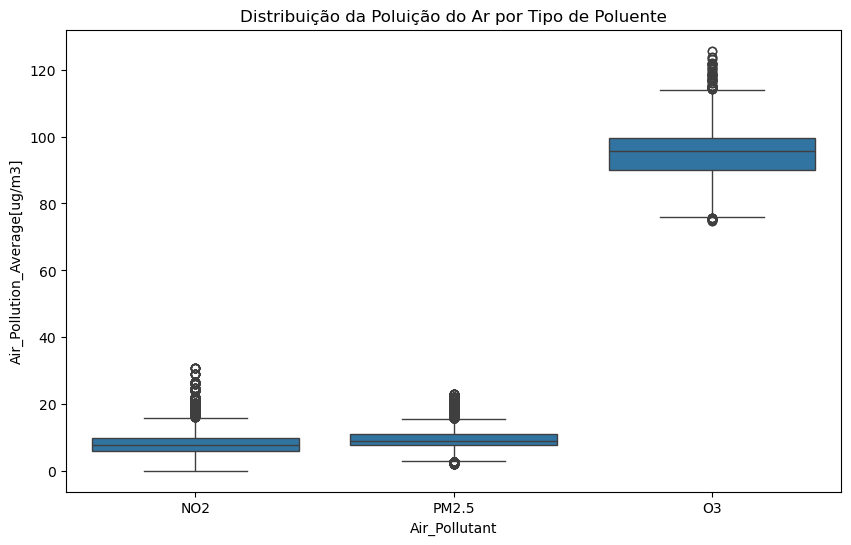

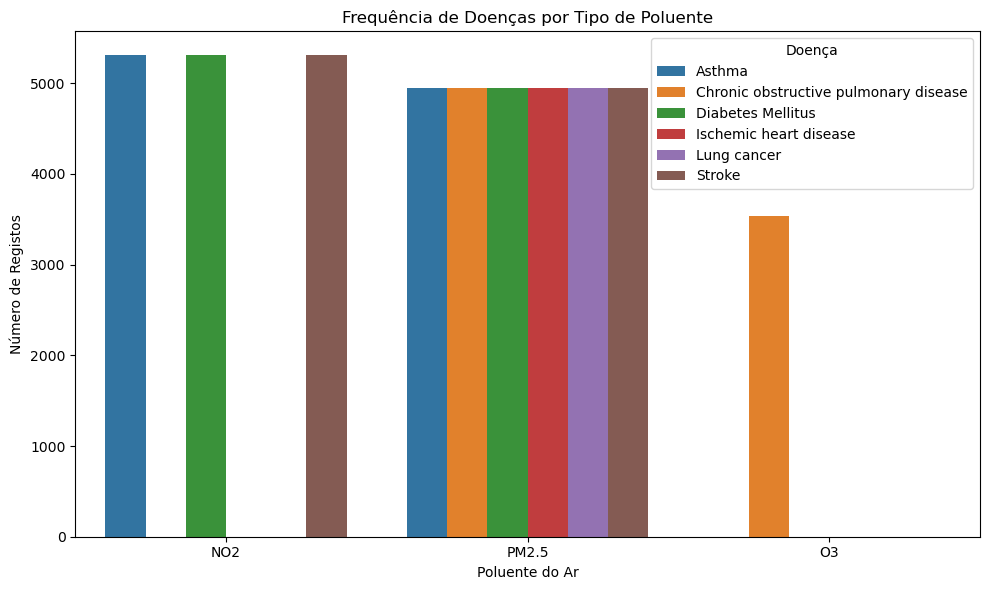

In [3]:
# Boxplot dos níveis médios de poluição por tipo de poluente
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Air_Pollutant', y='Air_Pollution_Average[ug/m3]')
plt.title("Distribuição da Poluição do Ar por Tipo de Poluente")
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Air_Pollutant', hue='Outcome')
plt.title("Frequência de Doenças por Tipo de Poluente")
plt.xlabel("Poluente do Ar")
plt.ylabel("Número de Registos")
plt.legend(title="Doença")
plt.tight_layout()
plt.show()

In [4]:
# Verificar dados em falta
print(df.isnull().sum())

# Remover ou imputar valores nulos
df = df.dropna()

# Remover duplicados
df = df.drop_duplicates()

# Confirmar tipos
print(df.dtypes)

df.head()

Country                         0
NUTS_Code                       0
Air_Pollutant                   0
Outcome                         0
Affected_Population             0
Populated_Area[km2]             0
Air_Pollution_Average[ug/m3]    0
Value                           0
dtype: int64
Country                          object
NUTS_Code                        object
Air_Pollutant                    object
Outcome                          object
Affected_Population             float64
Populated_Area[km2]             float64
Air_Pollution_Average[ug/m3]    float64
Value                           float64
dtype: object


,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0


In [5]:
# Listas de países por região
western = ['Austria', 'Belgium', 'France', 'Germany', 'Netherlands', 'Switzerland']
eastern = ['Poland', 'Czechia', 'Hungary']
southern = ['Greece', 'Spain', 'Italy', 'Portugal']
northern = ['Sweden', 'Denmark', 'Finland']

# Função para mapear
def get_region(country):
    if country in western:
        return 'Western Europe'
    elif country in eastern:
        return 'Eastern Europe'
    elif country in southern:
        return 'Southern Europe'
    elif country in northern:
        return 'Northern Europe'
    else:
        return 'Other'

# Aplicar ao dataset
df['Region'] = df['Country'].apply(get_region)

# Verificar agrupamento
df['Region'].value_counts()

df.head()

,Country,NUTS_Code,Air_Pollutant,Outcome,Affected_Population,Populated_Area[km2],Air_Pollution_Average[ug/m3],Value,Region
0,Albania,AL,NO2,Asthma,2337443.0,11299.0,5.5,103.0,Other
1,Albania,AL,PM2.5,Asthma,456076.0,11299.0,11.3,231.0,Other
2,Albania,AL0,NO2,Asthma,2337443.0,11299.0,5.5,103.0,Other
3,Albania,AL0,PM2.5,Asthma,456076.0,11299.0,11.3,231.0,Other
4,Albania,AL03,PM2.5,Asthma,149508.0,4041.5,11.3,69.0,Other


In [6]:
#4.2. Regressão  
# Considere apenas os países Southern Europe:

regression_data = df[df["Region"] == "Southern Europe"]

regression_data.head()
regression_data.dtypes

Country                          object
NUTS_Code                        object
Air_Pollutant                    object
Outcome                          object
Affected_Population             float64
Populated_Area[km2]             float64
Air_Pollution_Average[ug/m3]    float64
Value                           float64
Region                           object
dtype: object

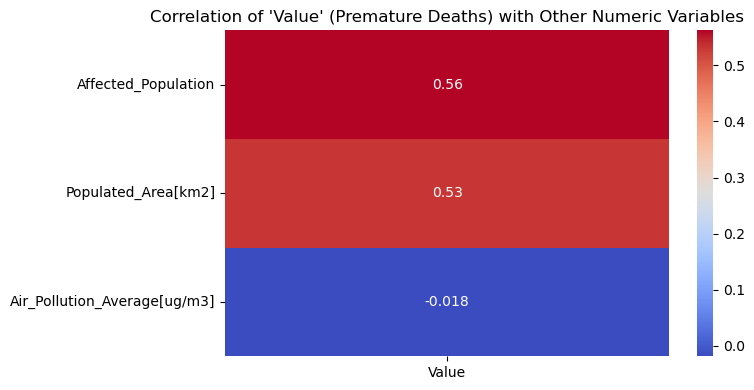

In [7]:
# 1 - Crie um diagrama de correlação entre a variável Premature_Deaths e os restantes atributos e interprete.

# Select only numeric columns
numeric_df = regression_data.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Focus only on correlation with 'Value'
value_corr = corr_matrix['Value'].drop('Value')  # Drop self-correlation

# Plot
plt.figure(figsize=(8, 4))
sns.heatmap(value_corr.to_frame(), annot=True, cmap='coolwarm', cbar=True)
plt.title("Correlation of 'Value' (Premature Deaths) with Other Numeric Variables")
plt.tight_layout()
plt.show()

In [8]:
# 2 - Usando o método k-fold cross validation obtenha um modelo regressão linear simples para a variável Premature_Deaths usando a variável 
# Affected_Population.

X = regression_data[['Affected_Population']]
y = regression_data['Value']

def kfold_indices(data, k):
    fold_size = len(data) // k
    indices = np.arange(len(data))
    folds = []
    for i in range(k):
        test_indices = indices[i * fold_size:(i + 1) * fold_size]
        train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
        folds.append((train_indices, test_indices))
    return folds

# Set up k-fold
k = 10
fold_indices = kfold_indices(X, k)

mae_scores = []
rmse_scores = []

for i, (train_idx, test_idx) in enumerate(fold_indices, start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fold {i} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}")

final_model = LinearRegression()
final_model.fit(X, y)

intercept = final_model.intercept_
coefficients = final_model.coef_[0]

Fold 1 -> MAE: 76.857, RMSE: 236.798
Fold 2 -> MAE: 275.223, RMSE: 1338.891
Fold 3 -> MAE: 425.639, RMSE: 1644.882
Fold 4 -> MAE: 259.117, RMSE: 936.341
Fold 5 -> MAE: 560.207, RMSE: 2849.807
Fold 6 -> MAE: 1037.902, RMSE: 4754.501
Fold 7 -> MAE: 248.227, RMSE: 597.212
Fold 8 -> MAE: 407.774, RMSE: 1137.765
Fold 9 -> MAE: 376.138, RMSE: 994.239
Fold 10 -> MAE: 853.260, RMSE: 2102.972


In [9]:
# a) Apresente a função linear resultante 

print("\nFinal Regression Formula:")
print(f"y = {intercept:.5f} + {coefficients:.5f}*(Affected_Population)")


Final Regression Formula:
y = -11.16206 + 0.00038*(Affected_Population)


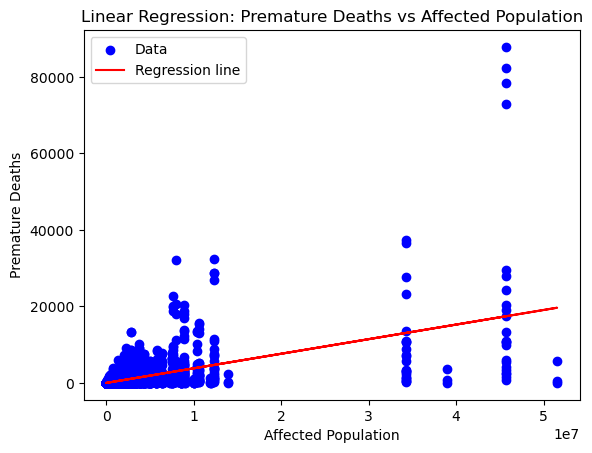

In [10]:
# b) Visualize a reta correspondente ao modelo de regressão linear simples e o respetivo diagrama de dispersão. 

# Plot the regression line and scatter plot
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, final_model.predict(X), color='red', label='Regression line')
plt.xlabel("Affected Population")
plt.ylabel("Premature Deaths")
plt.title("Linear Regression: Premature Deaths vs Affected Population")
plt.legend()
plt.show()

In [11]:
# c) Calcule o erro médio absoluto (MAE) e raiz quadrada do erro médio (RMSE) do modelo

# Final results
print("\nFinal Linear Regression Cross-Validation Results:")
print(f"Mean MAE: {np.mean(mae_scores):.5f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.5f}")


Final Linear Regression Cross-Validation Results:
Mean MAE: 452.03439
Mean RMSE: 1659.34088


In [12]:
# 3 - Usando o método k-fold cross validation desenvolva modelos para prever Premature_Deaths usando:
# a) Regressão linear múltipla.

features = ['Affected_Population', 'Air_Pollution_Average[ug/m3]', 'Populated_Area[km2]']
X = regression_data[features]
y = regression_data['Value']

# Set up k-fold
k = 10
fold_indices = kfold_indices(X, k)

mae_scores = []
rmse_scores = []

for i, (train_idx, test_idx) in enumerate(fold_indices, start=1):
    X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
    X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = math.sqrt(mean_squared_error(y_test, y_pred))

    mae_scores.append(mae)
    rmse_scores.append(rmse)

    print(f"Fold {i} -> MAE: {mae:.3f}, RMSE: {rmse:.3f}")

final_model = LinearRegression()
final_model.fit(X, y)
intercept = final_model.intercept_
coefficients = final_model.coef_

print("\nFinal Regression Formula:")
print(f"y = {intercept:.5f}", end="")
for feature, coef in zip(features, coefficients):
    print(f" + {coef:.5f}*({feature})", end="")
print()

print("\nFinal Multiple Linear Regression Cross-Validation Results:")
print(f"Mean MAE: {np.mean(mae_scores):.5f}")
print(f"Mean RMSE: {np.mean(rmse_scores):.5f}")

mae_multiple_linear = np.mean(mae_scores)
rmse_multiple_linear = np.mean(rmse_scores)

Fold 1 -> MAE: 95.636, RMSE: 239.490
Fold 2 -> MAE: 300.759, RMSE: 1346.319
Fold 3 -> MAE: 529.196, RMSE: 1856.829
Fold 4 -> MAE: 261.079, RMSE: 946.415
Fold 5 -> MAE: 577.145, RMSE: 2827.759
Fold 6 -> MAE: 1041.695, RMSE: 4740.640
Fold 7 -> MAE: 283.873, RMSE: 651.196
Fold 8 -> MAE: 436.062, RMSE: 1085.923
Fold 9 -> MAE: 343.673, RMSE: 919.836
Fold 10 -> MAE: 825.026, RMSE: 2078.321

Final Regression Formula:
y = 10.50835 + 0.00029*(Affected_Population) + -2.18226*(Air_Pollution_Average[ug/m3]) + 0.03195*(Populated_Area[km2])

Final Multiple Linear Regression Cross-Validation Results:
Mean MAE: 469.41453
Mean RMSE: 1669.27287


In [13]:
# b) Árvore de regressão. Otimize os parâmetros do modelo. Apresente a árvore de regressão obtida. 

# Features and target
X = regression_data[features]
y = regression_data['Value']

k = 10
fold_indices = kfold_indices(X, k)

best_mae = float('inf')
best_rmse = float('inf')
best_params = {}
best_model = None

best_fold_dt_maes = []
best_fold_dt_rmses = []

# Hyperparameter ranges
for max_depth in range(1, 21):
    for min_samples_split in range(2, 6):
        for min_samples_leaf in range(1, 5):
            
            mae_scores = []
            rmse_scores = []

            # New model for each parameter combination
            model = DecisionTreeRegressor(
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )

            # Cross-validation
            for train_idx, test_idx in fold_indices:
                X_train, y_train = X.iloc[train_idx], y.iloc[train_idx]
                X_test, y_test = X.iloc[test_idx], y.iloc[test_idx]

                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)

                mae = mean_absolute_error(y_test, y_pred)
                rmse = math.sqrt(mean_squared_error(y_test, y_pred))

                mae_scores.append(mae)
                rmse_scores.append(rmse)

            avg_mae = np.mean(mae_scores)
            avg_rmse = np.mean(rmse_scores)

            print(f"max_depth={max_depth}, min_samples_split={min_samples_split}, min_samples_leaf={min_samples_leaf} -> MAE: {avg_mae:.3f}, RMSE: {avg_rmse:.3f}")

            # Save best if lower MAE
            if avg_mae < best_mae:
                best_mae = avg_mae
                best_rmse = avg_rmse
                best_params = {
                    'max_depth': max_depth,
                    'min_samples_split': min_samples_split,
                    'min_samples_leaf': min_samples_leaf
                }
                best_model = model
                best_fold_dt_maes = mae_scores
                best_fold_dt_rmses = rmse_scores

# Final best model summary
print("\nBest model parameters:")
print(f"max_depth: {best_params['max_depth']}")
print(f"min_samples_split: {best_params['min_samples_split']}")
print(f"min_samples_leaf: {best_params['min_samples_leaf']}")
print(f"Best MAE: {best_mae:.5f}")
print(f"Best RMSE: {best_rmse:.5f}")

mae_tree = best_mae
rmse_tree = best_rmse

max_depth=1, min_samples_split=2, min_samples_leaf=1 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=2, min_samples_leaf=2 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=2, min_samples_leaf=3 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=2, min_samples_leaf=4 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=3, min_samples_leaf=1 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=3, min_samples_leaf=2 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=3, min_samples_leaf=3 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=3, min_samples_leaf=4 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=4, min_samples_leaf=1 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=4, min_samples_leaf=2 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=4, min_samples_leaf=3 -> MAE: 581.142, RMSE: 1873.259
max_depth=1, min_samples_split=4, min_samples_leaf=4 -> MAE: 581.

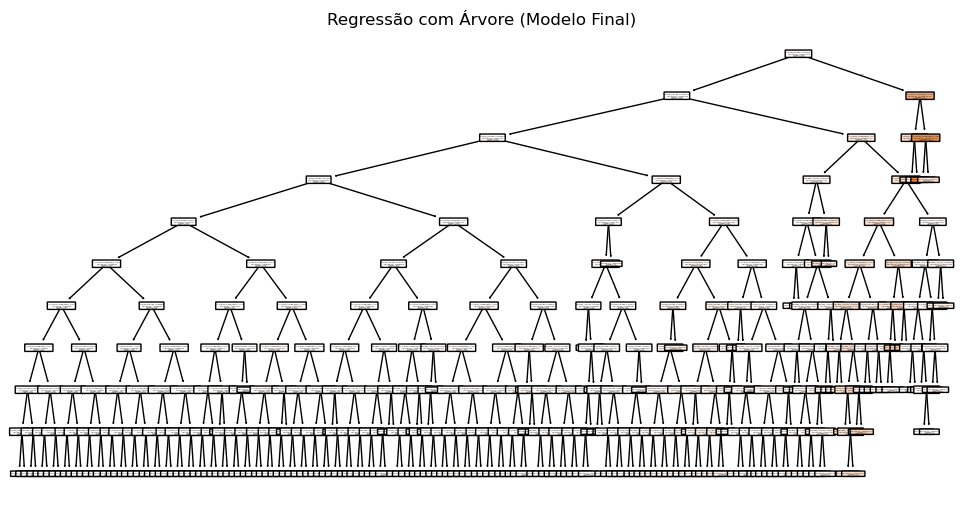

In [14]:
# Visualize the tree
plt.figure(figsize=(12, 6))
plot_tree(best_model, feature_names=features, filled=True, rounded=True)
plt.title("Regressão com Árvore (Modelo Final)")
plt.show()

In [15]:
# c) SVM. Otimize o kernel.

features = ['Affected_Population', 'Air_Pollution_Average[ug/m3]', 'Populated_Area[km2]']
X = regression_data[features]
y = regression_data['Value']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

k = 10
fold_indices = kfold_indices(X, k)

# Kernels to evaluate
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
gammas = [0.1, 1]

best_kernel_config = None
best_mae = float('inf')
best_rmse = float('inf')
results = {}

best_fold_svm_maes = []
best_fold_svm_rmses = []

total_runs = (len(kernels)-1) * len(gammas) * k + k
current_run = 0

# Try each kernel
for kernel in kernels:
    gamma_values = [None] if kernel == "linear" else gammas
    
    for gamma in gamma_values:
        fold_maes = []
        fold_rmses = []

        print(f"\nTesting kernel='{kernel}', gamma={gamma if gamma is not None else 'N/A'}")
    
        for i, (train_idx, test_idx) in enumerate(fold_indices):
            current_run += 1
            progress_pct = (current_run / total_runs) * 100
            print(f"Fold {i+1}/{k} | Progress: {progress_pct:.1f}%")
            
            X_train, y_train = X_scaled[train_idx], y.iloc[train_idx]
            X_test, y_test = X_scaled[test_idx], y.iloc[test_idx]

            if kernel == "linear":
                 model = SVR(kernel=kernel, C=1)
            else:
                 model = SVR(kernel=kernel, gamma=gamma, C=1)
                
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mae = mean_absolute_error(y_test, y_pred)
            rmse = math.sqrt(mean_squared_error(y_test, y_pred))

            fold_maes.append(mae)
            fold_rmses.append(rmse)

        mean_mae = np.mean(mae_scores)
        mean_rmse = np.mean(rmse_scores)
        results[(kernel, gamma)] = (mean_mae, mean_rmse)

        print(f"Kernel: {kernel}, Gamma: {gamma if gamma is not None else 'N/A'} -> Mean MAE: {mean_mae:.5f}, Mean RMSE: {mean_rmse:.5f}")

        if mean_mae < best_mae:
            best_mae = mean_mae
            best_rmse = mean_rmse
            best_kernel_config = (kernel, gamma)
            best_fold_svm_maes = fold_maes
            best_fold_svm_rmses = fold_rmses

# Final result
print("\n=== Final Best Kernel Configuration ===")
kernel_name, best_gamma = best_kernel_config
print(f"Best Kernel: {kernel_name}, Gamma: {best_gamma if best_gamma is not None else 'N/A'}")
print(f"Best Mean MAE: {best_mae:.5f}")
print(f"Best Mean RMSE: {best_rmse:.5f}")

mae_svm = best_mae
rmse_svm = best_rmse


Testing kernel='linear', gamma=N/A
Fold 1/10 | Progress: 1.4%
Fold 2/10 | Progress: 2.9%
Fold 3/10 | Progress: 4.3%
Fold 4/10 | Progress: 5.7%
Fold 5/10 | Progress: 7.1%
Fold 6/10 | Progress: 8.6%
Fold 7/10 | Progress: 10.0%
Fold 8/10 | Progress: 11.4%
Fold 9/10 | Progress: 12.9%
Fold 10/10 | Progress: 14.3%
Kernel: linear, Gamma: N/A -> Mean MAE: 432.59542, Mean RMSE: 1637.62121

Testing kernel='rbf', gamma=0.1
Fold 1/10 | Progress: 15.7%
Fold 2/10 | Progress: 17.1%
Fold 3/10 | Progress: 18.6%
Fold 4/10 | Progress: 20.0%
Fold 5/10 | Progress: 21.4%
Fold 6/10 | Progress: 22.9%
Fold 7/10 | Progress: 24.3%
Fold 8/10 | Progress: 25.7%
Fold 9/10 | Progress: 27.1%
Fold 10/10 | Progress: 28.6%
Kernel: rbf, Gamma: 0.1 -> Mean MAE: 432.59542, Mean RMSE: 1637.62121

Testing kernel='rbf', gamma=1
Fold 1/10 | Progress: 30.0%
Fold 2/10 | Progress: 31.4%
Fold 3/10 | Progress: 32.9%
Fold 4/10 | Progress: 34.3%
Fold 5/10 | Progress: 35.7%
Fold 6/10 | Progress: 37.1%
Fold 7/10 | Progress: 38.6%
Fold 


Testing config: hidden_layer_sizes=(50,)
Fold 1: MAE=591.75066, RMSE=1850.34923
Fold 2: MAE=532.02006, RMSE=2671.22231
Fold 3: MAE=405.81078, RMSE=1143.10023
Fold 4: MAE=401.29922, RMSE=1523.61420
Fold 5: MAE=591.26044, RMSE=3298.16341
Fold 6: MAE=517.62277, RMSE=1869.90924
Fold 7: MAE=548.09613, RMSE=1515.13205
Fold 8: MAE=535.01871, RMSE=1907.70413
Fold 9: MAE=460.12130, RMSE=1904.83189
Fold 10: MAE=468.07828, RMSE=2868.10276
Average MAE=505.10784, RMSE=2055.21295

Testing config: hidden_layer_sizes=(100,)
Fold 1: MAE=551.47563, RMSE=1830.28336
Fold 2: MAE=482.20816, RMSE=3131.03280
Fold 3: MAE=557.14642, RMSE=1810.86447
Fold 4: MAE=472.79656, RMSE=1632.19503
Fold 5: MAE=644.48600, RMSE=3728.49861
Fold 6: MAE=502.76478, RMSE=1842.37806
Fold 7: MAE=641.78259, RMSE=1776.40836
Fold 8: MAE=676.50552, RMSE=2408.39895
Fold 9: MAE=416.32707, RMSE=1773.37633
Fold 10: MAE=538.95935, RMSE=2686.92602
Average MAE=548.44521, RMSE=2262.03620

Testing config: hidden_layer_sizes=(50, 50)
Fold 1: MA

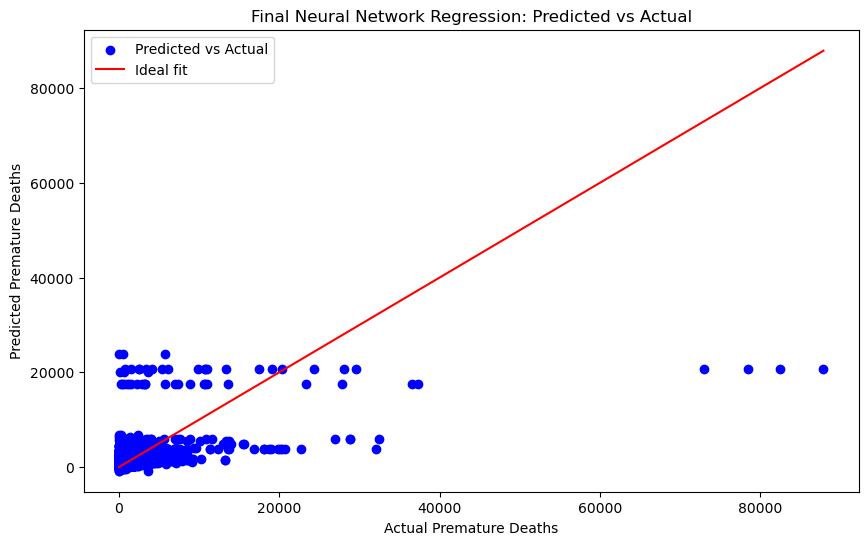

In [16]:
# d) Rede neuronal. Otimize a configuração da rede.

X = regression_data[features]
y = regression_data["Value"]

k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=42)

hidden_layer_options = [
    (50,),
    (100,),
    (50, 50),
    (100, 50),
    (128, 64, 32)
]

# Track best model
best_config = None
best_mae = float('inf')
best_rmse = float('inf')
best_nn_fold_maes = []
best_nn_fold_rmses = []
all_results = {}

for layers in hidden_layer_options:

    mae_scores = []
    rmse_scores = []
    r2_scores = []
    
    nn_config = {
        "activation": "relu",
        "hidden_layer_sizes": layers,
        "alpha": 0.001,
        "random_state": 42,
        "early_stopping": True,
        "max_iter": 1000
    }

    print(f"\nTesting config: hidden_layer_sizes={layers}")
    
    for fold, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = MLPRegressor(**nn_config)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = math.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        mae_scores.append(mae)
        rmse_scores.append(rmse)
        r2_scores.append(r2)

        print(f"Fold {fold}: MAE={mae:.5f}, RMSE={rmse:.5f}")

    mean_mae = np.mean(mae_scores)
    mean_rmse = np.mean(rmse_scores)
    mean_r2 = np.mean(r2_scores)

    all_results[layers] = {
        'MAE': mean_mae,
        'RMSE': mean_rmse,
        'R2': mean_r2
    }

    print(f"Average MAE={mean_mae:.5f}, RMSE={mean_rmse:.5f}")

    if mean_mae < best_mae:
        best_mae = mean_mae
        best_rmse = mean_rmse
        best_config = layers
        best_nn_fold_maes = mae_scores
        best_nn_fold_rmses = rmse_scores


# Final average scores
print("\n=== Final Cross-Validation Results (Neural Network) ===")
for layers, scores in all_results.items():
    print(f"Config {layers}: MAE={scores['MAE']:.5f}, RMSE={scores['RMSE']:.5f}")

print(f"\nBest configuration: {best_config}")
print(f"Best MAE: {best_mae:.5f}")
print(f"Best RMSE: {best_rmse:.5f}")

mae_nn = best_mae
rmse_nn = best_rmse

final_model = MLPRegressor(
    hidden_layer_sizes=best_config,
    activation="relu",
    alpha=0.001,
    random_state=42,
    early_stopping=True,
    max_iter=1000
)
final_model.fit(X, y)
y_final_pred = final_model.predict(X)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_final_pred, color="blue", label="Predicted vs Actual")
plt.plot([min(y), max(y)], [min(y), max(y)], color="red", label="Ideal fit")
plt.title("Final Neural Network Regression: Predicted vs Actual")
plt.xlabel("Actual Premature Deaths")
plt.ylabel("Predicted Premature Deaths")
plt.legend()
plt.show()

In [17]:
# 4. Compare os resultados obtidos pelos modelos referidos na questão 3, usando o erro médio absoluto (MAE) e a raiz quadrada do erro médio (RMSE).

print("\n=== 4. Comparison of Models (MAE & RMSE) ===")
print(f"Multiple Linear Regression -> MAE: {mae_multiple_linear:.5f}, RMSE: {rmse_multiple_linear:.5f}")
print(f"Decision Tree Regressor    -> MAE: {mae_tree:.5f}, RMSE: {rmse_tree:.5f}")
print(f"Support Vector Machine     -> MAE: {mae_svm:.5f}, RMSE: {rmse_svm:.5f}")
print(f"Neural Network             -> MAE: {mae_nn:.5f}, RMSE: {rmse_nn:.5f}")


=== 4. Comparison of Models (MAE & RMSE) ===
Multiple Linear Regression -> MAE: 469.41453, RMSE: 1669.27287
Decision Tree Regressor    -> MAE: 430.04103, RMSE: 1615.55760
Support Vector Machine     -> MAE: 432.59542, RMSE: 1637.62121
Neural Network             -> MAE: 468.72315, RMSE: 2054.78808


In [19]:
# 5 Justifique se os resultados obtidos para os dois melhores modelos são estatisticamente significativos 
# (para um nível de significância de 5%) e identifique o(s) modelo(s) com melhor desempenho.

from scipy.stats import ttest_rel

# === Template dictionaries for model errors ===
model_scores = {
    'Linear Regression': {
        'mae': mae_multiple_linear,
        'rmse': rmse_multiple_linear,
        'fold_mae': mae_scores,
        'fold_rmse': rmse_scores
    },
    'Decision Tree': {
        'mae': mae_tree,
        'rmse': rmse_tree,
        'fold_mae': best_fold_dt_maes,
        'fold_rmse': best_fold_dt_rmses
    },
    'SVM': {
        'mae': mae_svm,
        'rmse': rmse_svm,
        'fold_mae': best_fold_svm_maes,
        'fold_rmse': best_fold_svm_rmses
    },
    'Neural Network': {
        'mae': mae_nn,
        'rmse': rmse_nn,
        'fold_mae': best_nn_fold_maes,
        'fold_rmse': best_nn_fold_rmses
    }
}

# === Sort models by mean MAE ===
sorted_models = sorted(model_scores.items(), key=lambda x: x[1]['mae'])

# === Select the top 2 ===
best_model_name, best_model_data = sorted_models[0]
second_model_name, second_model_data = sorted_models[1]

print(f"\nTop 2 models based on lowest MAE:")
print(f"1. {best_model_name} -> MAE: {best_model_data['mae']:.5f}")
print(f"2. {second_model_name} -> MAE: {second_model_data['mae']:.5f}")

# === Paired t-tests ===

# MAE t-test
t_stat_mae, p_val_mae = ttest_rel(best_model_data['fold_mae'], second_model_data['fold_mae'])
print(f"\nMAE Paired t-test between {best_model_name} and {second_model_name}:")
print(f"t = {t_stat_mae:.4f}, p = {p_val_mae:.4f}")
if p_val_mae < 0.05:
    print("MAE difference is statistically significant at the 5% level.")
else:
    print("MAE difference is NOT statistically significant at the 5% level.")

# RMSE t-test
t_stat_rmse, p_val_rmse = ttest_rel(best_model_data['fold_rmse'], second_model_data['fold_rmse'])
print(f"\nRMSE Paired t-test between {best_model_name} and {second_model_name}:")
print(f"t = {t_stat_rmse:.4f}, p = {p_val_rmse:.4f}")
if p_val_rmse < 0.05:
    print("RMSE difference is statistically significant at the 5% level.")
else:
    print("RMSE difference is NOT statistically significant at the 5% level.")


Top 2 models based on lowest MAE:
1. Decision Tree -> MAE: 430.04103
2. SVM -> MAE: 432.59542

MAE Paired t-test between Decision Tree and SVM:
t = 0.8087, p = 0.4396
MAE difference is NOT statistically significant at the 5% level.

RMSE Paired t-test between Decision Tree and SVM:
t = -0.6808, p = 0.5132
RMSE difference is NOT statistically significant at the 5% level.
